In [1]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import collections
import matplotlib.pylab as plt
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_curve, average_precision_score, roc_auc_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

%cd /content/drive/MyDrive/DSGA_1006_Capstone/
from DataProcessing import DataClean, DataSeparation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Mounted at /content/drive
/content/drive/MyDrive/DSGA_1006_Capstone


device(type='cpu')

## Get the data

In [ ]:
table_path = 'data/neural_net_all_yahoo_paring_scores_for_neural_net.csv'
data_clean = DataClean(table_path)

(5537, 384)
(5537, 384)
(5537, 1)


In [ ]:
post_embeddings, video_embeddings, labels = data_clean.get_data()
# map 'offensive' to 'bad'
labels = np.array([0 if label == 2 else int(label) for label in labels], dtype=object)
np.unique(labels, return_counts=True)

(array([0, 1], dtype=object), array([3463, 2074]))

3463 unmatch(bad) and 2074 match(good)

ratio $≈$ **7 : 4**, 63.6% positive class

## Dataset Class

In [ ]:
random_seed = 0
train_ratio = 0.8
validation_ratio = 0.1

dataseparation = DataSeparation(post_embeddings, video_embeddings, labels, train_ratio, validation_ratio, random_seed)
post_data, video_data, label_data, indices = dataseparation.get_data()

In [ ]:
class PostVideoPairDataset(Dataset):
    def __init__(self, post_embeddings, video_embeddings, labels):
        self.post_embeddings = post_embeddings
        self.video_embeddings = video_embeddings
        self.labels = labels

    def __len__(self):
        return self.post_embeddings.shape[0]

    def __getitem__(self, idx):
        post_embedding = self.post_embeddings[idx]
        video_embedding = self.video_embeddings[idx]
        label = self.labels[idx]

        data = {'post_embedding': torch.from_numpy(post_embedding).to(torch.float32).to(device),\
               'video_embedding': torch.from_numpy(video_embedding).to(torch.float32).to(device),\
               'label': torch.tensor(label).to(torch.int64).to(device)}

        return data

In [ ]:
train_dataset = PostVideoPairDataset(post_data['train'], video_data['train'], label_data['train'])
validation_dataset = PostVideoPairDataset(post_data['validation'], video_data['validation'], label_data['validation'])
test_dataset = PostVideoPairDataset(post_data['test'], video_data['test'], label_data['test'])

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size = 128, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = 129, shuffle = False)

## Neural Net

In [ ]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNeuralNet, self).__init__()

        self.classification_tower = nn.Sequential(
                        nn.Linear(input_dim * 2, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, post_embeddings, video_embeddings):

        combined = torch.cat((post_embeddings, video_embeddings), dim = 1)

        output = self.classification_tower(combined)

        return output



input_dim = 384
hidden_dim = 100
output_dim = 2
lr = 2e-4

# input_dim = 384
# hidden_dim = 64
# output_dim = 2
# lr = 1e-3

model = SimpleNeuralNet(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

## Evaluation using PR curve & ROC curve

In [ ]:
folds = 1000

def plot_roc_pr_ensemble_thresholds(model_probs_orig, y_test_orig, Name = 'train', EPOCH = None):
    mean_rec = np.linspace(0, 1, 10*len(y_test_orig))
    mean_fpr = np.linspace(0, 1, 10*len(y_test_orig))
    # print(y_test_orig.shape)
    # model_precision, model_recall, thresholds_orig = precision_recall_curve(y_test_orig, model_probs_orig)

    # majority_class = 1 if y_test_orig.sum() > 0.5*y_test_orig.shape[0] else 0
    # print('dummy model, simply predicting marjority class which is:', majority_class)

    # using half of the data for bootstrap
    pcnt_boot = 0.5

    ppvs = np.zeros((folds,  10*len(y_test_orig)), dtype=np.float32)
    tprs = np.zeros((folds,  10*len(y_test_orig)), dtype=np.float32)
    model_aps_list = []
    model_auc_list = []

    for epoch in range(folds):
        ix_subset = np.arange(len(y_test_orig))
        np.random.shuffle(ix_subset)
        ix_subset = ix_subset[0:int(pcnt_boot*len(y_test_orig))]

        y_test_i = y_test_orig[ix_subset]
        model_probs = model_probs_orig[ix_subset]

        model_precision, model_recall, thresholds = precision_recall_curve(y_test_i, model_probs)
        interp_prc = np.interp(mean_rec, model_recall[::-1], model_precision[::-1])

        ppvs[epoch, :] = interp_prc


        model_fpr, model_tpr, auc_thresholds = roc_curve(y_test_i, model_probs)
        interp_tpr = np.interp(mean_fpr, model_fpr, model_tpr)
        tprs[epoch, :] = interp_tpr

        model_aps = average_precision_score(y_test_i, model_probs)
        model_aps_list.append(model_aps)
        model_auc = roc_auc_score(y_test_i, model_probs)
        model_auc_list.append(model_auc)
    model_aps_list = np.array(model_aps_list)
    model_auc_list = np.array(model_auc_list)

    if Name is not None: ## only plot for test otherwise output too long
        plt.figure(figsize=(20,9))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)


        mean_ppv = ppvs.mean(axis=0)
        std_ppv = np.std(ppvs, axis=0)
        ppvs_upper = np.minimum(mean_ppv + std_ppv, 1) #1.96*(std_ppv)/np.sqrt(folds)
        ppvs_lower = np.maximum(mean_ppv - std_ppv, 0) #1.96*(std_ppv)/np.sqrt(folds)
        ax1.plot(mean_rec, ppvs.mean(axis=0).ravel(),
                label='Precision Recall Curve \nAverage Precision:{:.7f}[{:.7f} {:.7f}]'.format(
                    model_aps_list.mean(),
                    model_aps_list.mean() - 1.96*(model_aps_list.std())/np.sqrt(folds),
                    model_aps_list.mean() + 1.96*(model_aps_list.std())/np.sqrt(folds)
                ),
                alpha=1)
        ax1.fill_between(mean_rec, ppvs_lower, ppvs_upper, color='blue', alpha=.2,
                        label='Standard Deviation')

        ax1.set_xlabel('Recall (Sensitivity)',fontsize=18)
        ax1.set_ylabel('Precision (Positive Predictive Value)',fontsize=18)
        ax1.legend(loc="upper right",fontsize=14)
        ax1.grid()
        ax1.tick_params(axis="x", labelsize=14)
        ax1.tick_params(axis="y", labelsize=14)
        ax1.set_title('Precision Recall Curve', fontsize=18)


        mean_tpr = tprs.mean(axis=0)
        std_tpr = np.std(tprs, axis=0)
        #print(std_tpr)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1) #1.96*(std_tpr)/np.sqrt(folds)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)# 1.96*(std_tpr)/np.sqrt(folds)
        ax2.plot(mean_fpr, mean_tpr, label='ROC Curve \nAUC:{:.7f}[{:.7f} {:.7f}]'.format(
                    model_auc_list.mean(),
                    model_auc_list.mean() - 1.96*(model_auc_list.std())/np.sqrt(folds),
                    model_auc_list.mean() + 1.96*(model_auc_list.std())/np.sqrt(folds)
                ), alpha=1)
        ax2.fill_between(mean_fpr, tprs_lower, tprs_upper, color='blue', alpha=.2,
                        label='Standard Deviation')

        ax2.set_xlabel('False Positive Rate',fontsize=18)
        ax2.set_ylabel('True Positive Rate',fontsize=18)
        ax2.legend(loc="lower right",fontsize=14)
        ax2.grid()
        ax2.tick_params(axis="x", labelsize=14)
        ax2.tick_params(axis="y", labelsize=14)
        ax2.set_title('Receiver Operating Characteristic Curve', fontsize=18)

        ax1.set_xlim([0, 1.01])
        ax1.set_ylim([0, 1.01])
        ax2.set_xlim([0, 1.01])
        ax2.set_ylim([0, 1.01])

    # training process and validation process need to record which epoch we are in
    # test process does not need epoch
    if Name == 'train':
        path = '/content/drive/MyDrive/DSGA_1006_Capstone/Simple_Neural_Net/evaluation_plots/train/'
    elif Name == 'validation':
        path = '/content/drive/MyDrive/DSGA_1006_Capstone/Simple_Neural_Net/evaluation_plots/validation/'
    else:
        path = '/content/drive/MyDrive/DSGA_1006_Capstone/Simple_Neural_Net/evaluation_plots/test/'

    if EPOCH is not None:
        # train or validation
        print(str(EPOCH + 1))

        # fname = path + 'epoch_' + str(EPOCH+1) + '.png'
        # plt.savefig(fname)
    else:
        # test
        fname = path + 'test_original.png'
        plt.savefig(fname)
    plt.show()

    return mean_rec, ppvs.mean(axis=0).ravel(), model_aps_list.mean(), model_auc_list.mean()

## Train & Validation & Test

In [ ]:
log_interval = 5

def train(epoch):
    model.train()
    for batch_idx, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(data['post_embedding'], data['video_embedding'])
        loss = criterion(output, data['label'].squeeze())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data['post_embedding']), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()))

In [ ]:
def validation(epoch):
    model.eval()
    validation_loss = 0
    true_labels = []
    pred_probs = []
    correct = 0

    for data in validation_dataloader:
        output = model(data['post_embedding'], data['video_embedding'])
        validation_loss += criterion(output, data['label'].squeeze()).cpu().item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(data['label'].view_as(pred)).cpu().sum()

        true_labels.extend(data['label'].squeeze().cpu().tolist())
        pred_probs.extend(F.softmax(output, dim = 1)[:, 1].squeeze().to('cpu').detach().tolist())


    true_labels = np.array(true_labels)
    pred_probs = np.array(pred_probs)

    validation_loss /= len(validation_dataloader.dataset)
    accu = 100. * correct / len(validation_dataloader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        validation_loss, correct, len(validation_dataloader.dataset), accu))

    recalls, precisions, avg_precision, avg_auc = plot_roc_pr_ensemble_thresholds(pred_probs, true_labels, 'validation', epoch)

    return recalls, precisions, avg_precision, avg_auc, accu

In [ ]:
def test():
    model.eval()
    test_loss = 0
    true_labels = []
    pred_probs = []
    correct = 0

    for data in test_dataloader:
        output = model(data['post_embedding'], data['video_embedding'])
        test_loss += criterion(output, data['label'].squeeze()).cpu().item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(data['label'].view_as(pred)).cpu().sum()

        true_labels.extend(data['label'].squeeze().cpu().tolist())
        pred_probs.extend(F.softmax(output, dim = 1)[:, 1].squeeze().to('cpu').detach().tolist())

    true_labels = np.array(true_labels)
    pred_probs = np.array(pred_probs)

    test_loss /= len(test_dataloader.dataset)
    accu = 100. * correct / len(test_dataloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset), accu))

    recalls, precisions, avg_precision, avg_auc = plot_roc_pr_ensemble_thresholds(pred_probs, true_labels, 'test')

    return recalls, precisions, avg_precision, avg_auc, accu


Validation set: Average loss: 0.0063, Accuracy: 213/554 (38.45%)

0


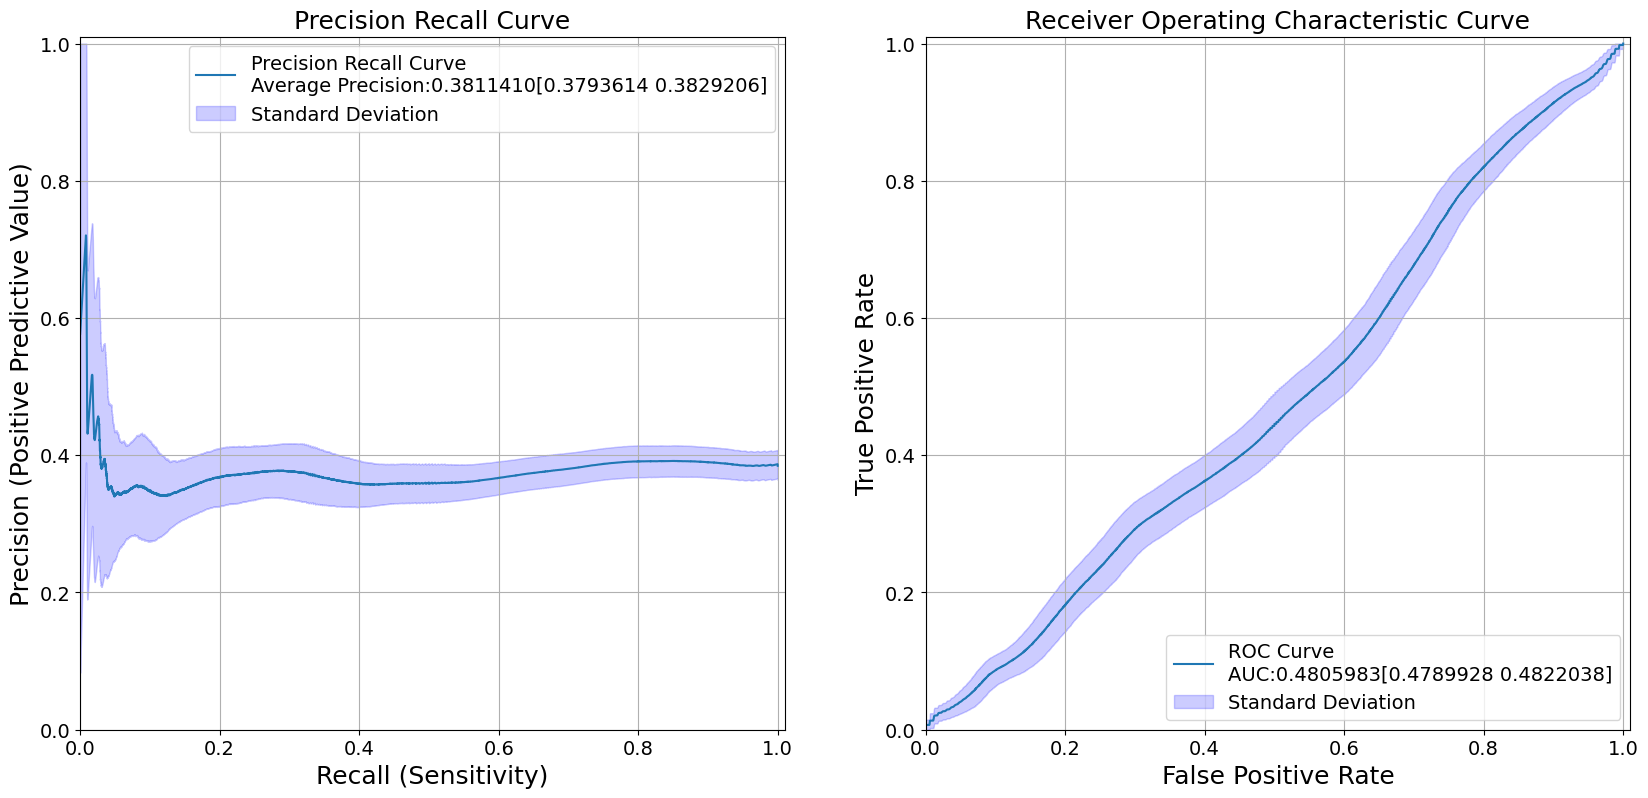

In [ ]:
# initial model on validation set
recalls, precisions, avg_precision, avg_auc, accu = validation(-1)


Test set: Average loss: 0.0063, Accuracy: 217/554 (39.17%)



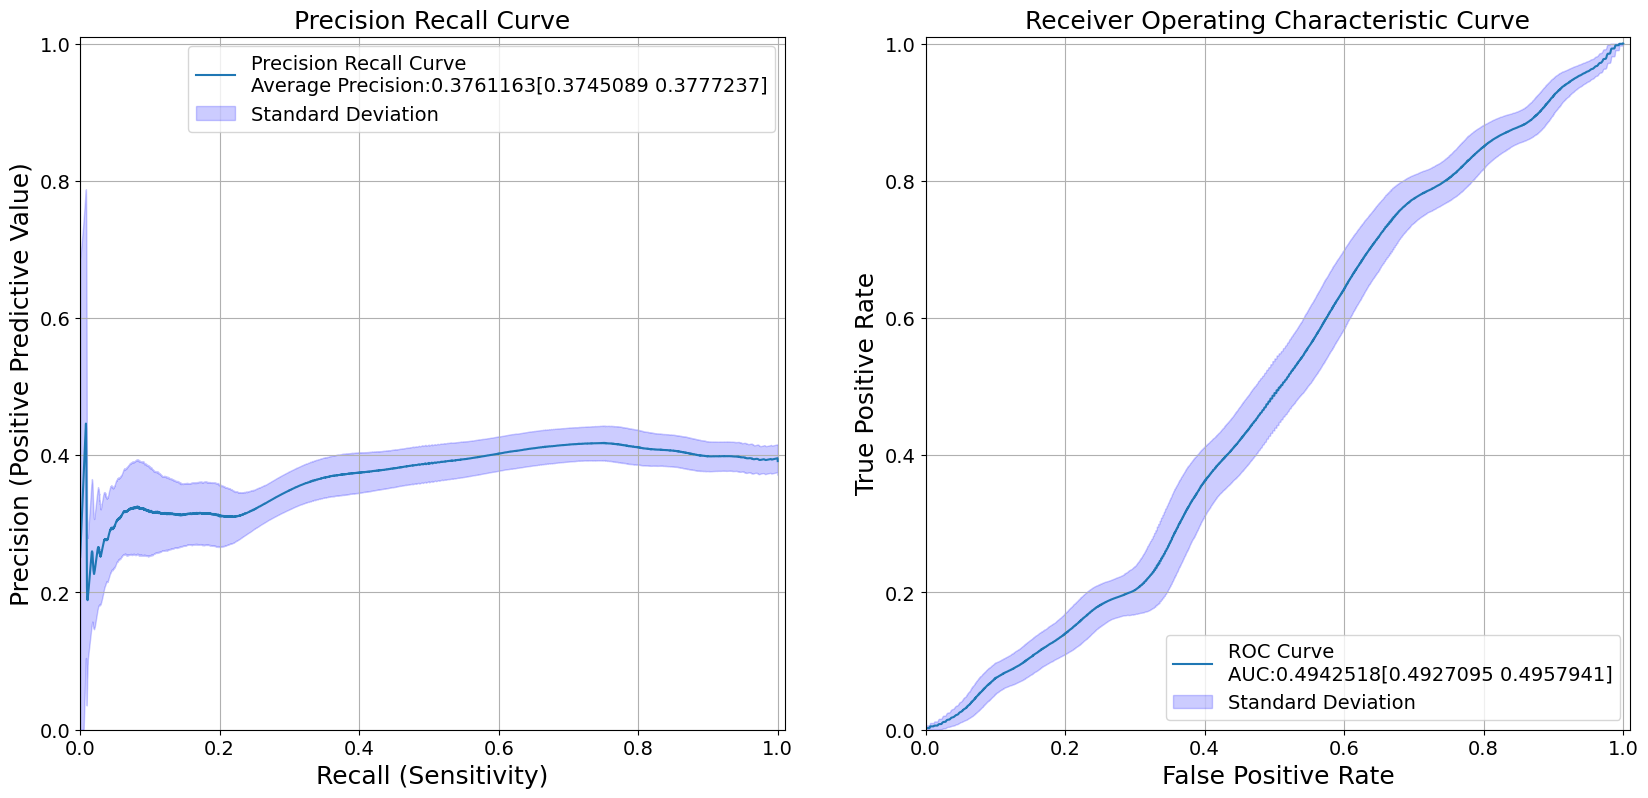

In [ ]:
# initial model on test set
recalls, precisions, avg_precision, avg_auc, accu = test()

In [ ]:
# train the model

epochs = 150
avg_precisions = []
max_avg_precision = 0.0
avg_aucs = []
accuracies = []

#max_accu = 0.0
for epoch in range(epochs):
    train(epoch)
    recalls, precisions, avg_precision, avg_auc, accu = validation(epoch)
    avg_precisions.append(avg_precision)
    avg_aucs.append(avg_auc)
    accuracies.append(accu)

    # save the model with the best accuracy on validation set
    if epoch == 0:
        max_avg_precision = avg_precision
        torch.save(model, '/content/drive/MyDrive/DSGA_1006_Capstone/Simple_Neural_Net/model_save/original_best_model_val.pt')
    elif epoch > 0:
        if avg_precision > max_avg_precision:
            max_avg_precision = avg_precision
            torch.save(model, '/content/drive/MyDrive/DSGA_1006_Capstone/Simple_Neural_Net/model_save/original_best_model_val.pt')

Output hidden; open in https://colab.research.google.com to view.


Test set: Average loss: 0.0050, Accuracy: 440/554 (79.42%)



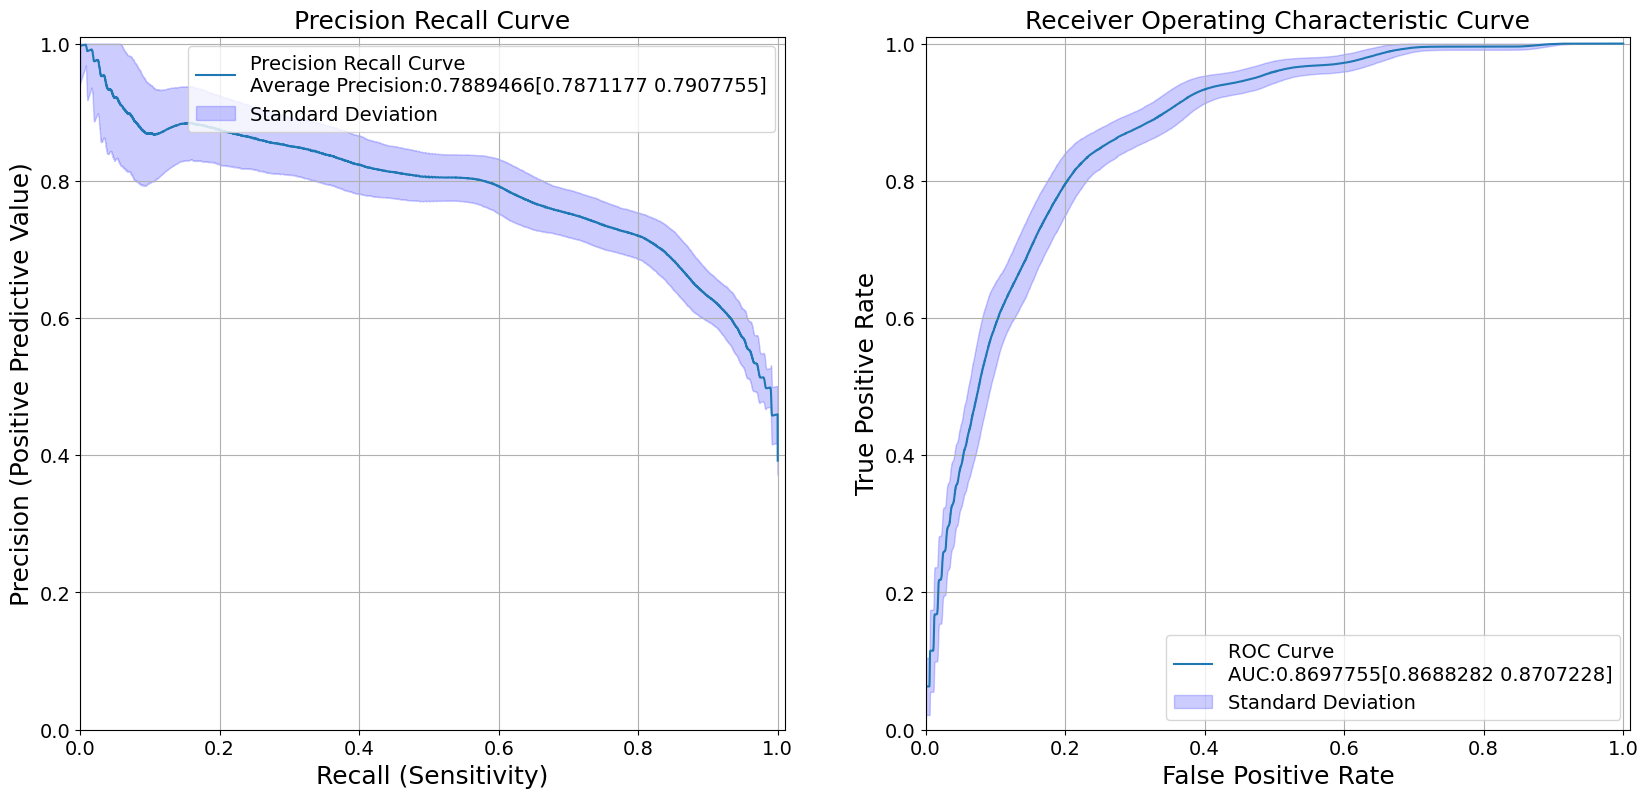

In [ ]:
model = torch.load('/content/drive/MyDrive/DSGA_1006_Capstone/Simple_Neural_Net/model_save/original_best_model_val.pt')
recalls, precisions, avg_precision, avg_auc, accu = test()

Text(0.5, 1.0, 'Precisions')

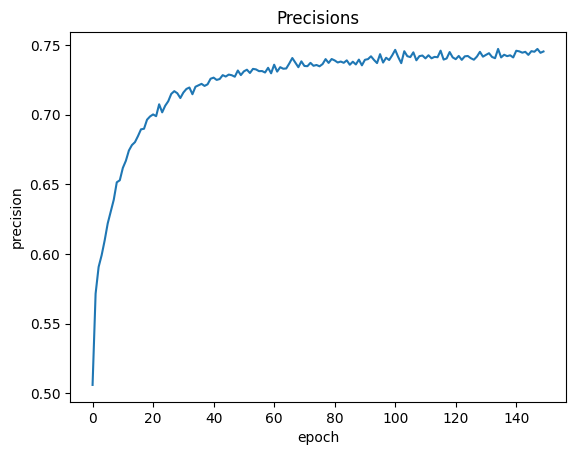

In [ ]:
plt.plot(avg_precisions)
plt.xlabel('epoch')
plt.ylabel('precision')
plt.title('Precisions')

Text(0.5, 1.0, 'AUCs')

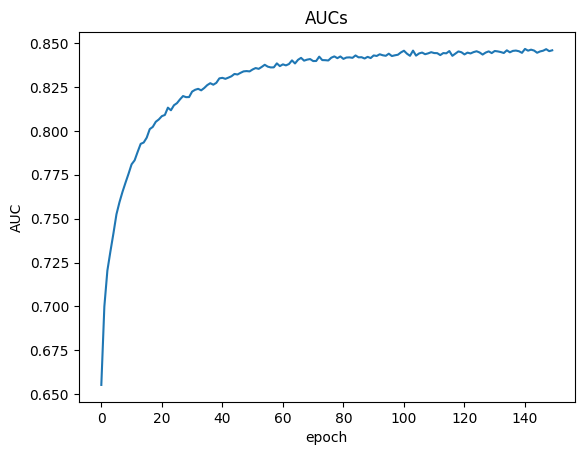

In [ ]:
plt.plot(avg_aucs)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUCs')

Text(0.5, 1.0, 'Accuracies')

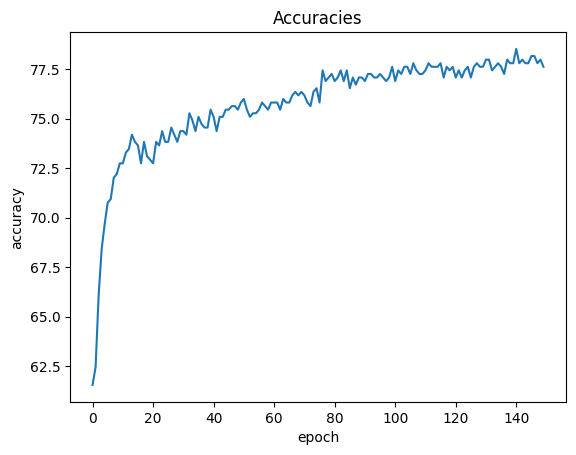

In [ ]:
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracies')

# Model Evaluation

## Top1 recommendation on validation


In [ ]:
df = pd.read_csv(table_path)
## Read df
model = torch.load('Simple_Neural_Net/model_save/original_best_model_val.pt')
video_embeds = pd.read_csv('data/video_embeds/video_embeds.csv.gz', compression='gzip')
## preprocess video embeddings, the format is clean here
all_video_embeds = video_embeds.EMBED.apply( lambda x: list( map(lambda y: float(y), x.strip("[[").strip("]]").split(','))) )
## Get the shape
num_video, _ = video_embeds.shape
## Some information here
num_video, len(all_video_embeds), type(all_video_embeds[0][0])

(6387, 6387, float)

In [ ]:
## Take first 150 Articles in val dataset
validation_article_emb = post_data['validation'][:150] #### sample from all 23k articles
validation_article_emb.shape, all_video_embeds.shape

((150, 384), (6387,))

In [ ]:
## Generate 6387 scores for every article
num_article = len(validation_article_emb)
scores = torch.zeros((num_article, num_video))
# recommendations = {}
video_emb = torch.tensor(all_video_embeds).float()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

video_emb = torch.tensor(all_video_embeds).float().to(device)  # move to cude

batch_size = 32  # make batch

for i in range(0, num_article, batch_size):
    end_idx = min(i + batch_size, num_article)
    batch_article_emb = torch.tensor(validation_article_emb[i:end_idx]).float().to('cuda')

    # (batch_size, num_video, 384)
    article_emb_expanded = batch_article_emb.unsqueeze(1).expand(-1, num_video, -1)

    # (batch_size * num_video, 384)
    article_emb_reshaped = article_emb_expanded.reshape(-1, 384)

    model.to(device)
    output = model(article_emb_reshaped, video_emb.repeat(batch_article_emb.shape[0], 1))
    batch_scores = F.softmax(output, dim=1)[:, 1].view(batch_article_emb.shape[0], num_video)

    # save the score
    scores[i:end_idx] = batch_scores.cpu()  # move back to cpu

    torch.cuda.empty_cache()

# top 1 recommendation
recommend_score, recommend_idx = torch.max(scores, dim=1)

In [ ]:
print( recommend_score )
recommend_idx, recommend_idx.shape, torch.unique(recommend_idx).shape

### test code

In [ ]:
top5_scores, top5_indices = torch.topk(scores, 10, dim=1) #5/10
top5_scores[:15], top5_indices[:15], torch.unique(top5_indices[:15].flatten()).shape

In [ ]:
pd.set_option('display.max_colwidth', None)
## Generate a new df with article title, recommended video title, score
df_to_eval = df.loc[indices['validation'][:150], ['post_title']].reset_index(drop=True)
df_to_eval['video_title'] = video_embeds.loc[recommend_idx, ['TITLE']].reset_index(drop=True)
df_to_eval['score'] = recommend_score.detach().numpy()
df_to_eval['human_label'] = 0 # requires manual labeling

In [ ]:
df_to_eval

,post_title,video_title,score,human_label
0,"As news of Andrew Tate's arrest goes viral, influencers are trying to mobilize their fanbases in his defense",Why Sam Bankman-Fried is charged with perpetuating one of the biggest frauds in US history,0.994306,0
1,"China is still racing to develop its own mRNA jabs. But they won't use foreign vaccines to fight COVID because of 'national pride,' says South Korea's top vaccine maker.",The coronavirus could affect the accuracy of the 2020 census — and that could decide who gets a vaccine,0.999571,0
2,"The awkward, technical truth behind Hollywood sex scenes",How Jennifer Lopez went from unknown backup dancer to music icon,0.999504,0
3,"Take a look behind the scenes of 'Avatar: The Way of Water,' including the giant tank where James Cameron filmed much of the movie",14 reasons to visit the Hawaiian islands,0.998346,0
4,Russian embassy accidentally shares map ignoring Putin's bogus land claims in Ukraine,How 27 countries sent Ukraine more than $1 billion of weapons and supplies in one week,0.993542,0
...,...,...,...,...
145,Elon Musk has lost so much money that the Guinness World Records recognized him for the 'largest loss of personal fortune in history',CEO of blockchain company Chain on what everyone gets wrong about the technology,0.999741,0
146,"A scientist's recordings reveal turtles coo, squeak, and croak. Listen to their rarely-heard calls.",11 places to go only if you aren't afraid of heights,0.999016,0
147,US stocks turn higher on optimism that inflation will cool further and allow the Fed to ease tightening,Why Sam Bankman-Fried is charged with perpetuating one of the biggest frauds in US history,0.999701,0
148,"DeSantis' second inauguration as governor will have a 'Free State of Florida' theme, a Carbone-catered candlelight dinner, and a toast to moms supporting the GOP governor",CEO of blockchain company Chain on what everyone gets wrong about the technology,0.997973,0


In [ ]:
## Specific classes to classify
## Ask GPT4 to generate rating 1-10 for new pairs, 50 pairs each time. Ran 3 times here

Question = "Please rate each (Article Title, Video Title) pair from 1 to 10, where 1 represents totally unmatch, 10 represents perfect match. Try to rate based on how appropriate it is to embed the video into the article in oneline media website. Please focus on high level information such as Subjects, Verticals, Domains, etc. If one of the titles is related to business, law, news or politics, the other one should lie within the same Vertical. Please output a python list of ratings in integer."

# for i in range(101, 150):
#     Question += f"Article Title {i}: {df_to_eval.loc[i, 'post_title']}; Video Title {i}: {df_to_eval.loc[i, 'video_title']}\n\n"
Question[:-2]

## Top1 recommendation on sample of 23k articles

In [ ]:
## Load our model
model = torch.load('Simple_Neural_Net/model_save/best_model_val.pt')

## preprocess articles embeddings, the format is clean here
article_embeds = pd.read_csv('data/content_embeds/content_embeds.csv.gz', compression='gzip')
article_embeds.EMBED = article_embeds.EMBED.apply( lambda x: list( map(lambda y: float(y), x.strip("[[").strip("]]").split(','))) )

## preprocess video embeddings, the format is clean here
video_embeds = pd.read_csv('data/video_embeds/video_embeds.csv.gz', compression='gzip')
video_embeds.EMBED = video_embeds.EMBED.apply( lambda x: list( map(lambda y: float(y), x.strip("[[").strip("]]").split(','))) )
all_video_embeds = video_embeds.EMBED
## Get the shape
num_video, _ = video_embeds.shape
## Some information here
num_video, len(all_video_embeds), type(all_video_embeds[0][0])

(6387, 6387, float)

In [ ]:
## Random sample 100 articles
np.random.seed(42)
subset_article_df = article_embeds.loc[ np.random.choice( article_embeds.shape[0], size=100, replace=False), :]
subset_article_emb = torch.tensor( np.array(subset_article_df.EMBED.to_list()) )

## Generate 6387 scores for every article
num_article = len(subset_article_emb)
scores = torch.zeros((num_article, num_video))
video_emb = torch.tensor(all_video_embeds).float()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
video_emb = torch.tensor(all_video_embeds).float().to(device)  # move to cude

batch_size = 16  # make batch

for i in range(0, num_article, batch_size):
    end_idx = min(i + batch_size, num_article)
    batch_article_emb = torch.tensor(subset_article_emb[i:end_idx]).float().to('cuda')

    # (batch_size, num_video, 384)
    article_emb_expanded = batch_article_emb.unsqueeze(1).expand(-1, num_video, -1)

    # (batch_size * num_video, 384)
    article_emb_reshaped = article_emb_expanded.reshape(-1, 384)

    model.to(device)
    output = model(article_emb_reshaped, video_emb.repeat(batch_article_emb.shape[0], 1))
    batch_scores = F.softmax(output, dim=1)[:, 1].view(batch_article_emb.shape[0], num_video)

    # save the score
    scores[i:end_idx] = batch_scores.cpu()  # move back to cpu

    torch.cuda.empty_cache()

# top 1 recommendation
recommend_score, recommend_idx = torch.max(scores, dim=1)

<ipython-input-57-c610c6962dc8>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_article_emb = torch.tensor(subset_article_emb[i:end_idx]).float().to('cuda')


In [ ]:
pd.set_option('display.max_colwidth', None)
## Generate a new df with article title, recommended video title, score
df_to_eval = subset_article_df[['TITLE']].reset_index(drop=True).rename(columns={'TITLE': 'article_title'})
# df_to_eval['article_emb'] = subset_article_df[['EMBED']].reset_index(drop=True)
df_to_eval['video_title'] = video_embeds.loc[recommend_idx, ['TITLE']].reset_index(drop=True)
# df_to_eval['video_emb'] = video_embeds.loc[recommend_idx, ['EMBED']].reset_index(drop=True)
df_to_eval['score'] = recommend_score.detach().numpy()

df_to_eval.to_csv("prompt_engineering/sample_100_recommend_best_model.csv")

df_to_eval

,article_title,video_title,score
0,Shows like Netflix's live-action 'One Piece' to watch while you're waiting for season 2,How Icelandic Skyr Yoghurt Cheese is made,0.858191
1,Mike Tyson calls Jake Paul his 'hero' and says the YouTuber has done more for boxing than some champions,How actors fake fight in movies,0.999435
2,A radio presenter who lost weight and built muscle six months before turning 30 says he's made habits for life,Physical therapists debunk 14 more myths about exercise and fitness,0.997589
3,"25 best winter coats for women in 2023, tested by cold weather experts",Inside Emirates’ newest and most luxurious first-class suite,0.878802
4,The Google Pixel 3 has the best smartphone camera you can buy right now — here's why,7 pre-CGI tricks used in classic Hollywood movies,0.986344
...,...,...,...
95,Where to watch a free Alcaraz vs. Medvedev live stream at US Open,A robotics lab created an exoskeleton that assists people with neurological disorders.,0.955065
96,"The Ukraine War has accelerated research into lithium-ion battery alternatives, including ones made of sand","The cause of all war boils down to sex and social status, according to a conflict expert who used to be in the British army",0.999680
97,"Hunter Biden sues IRS, claims whistleblower agents 'targeted and sought to embarrass' him by discussing his tax returns",House committee targets Mark Meadows as texts reveal his role and Trump's inaction on January 6,0.963086
98,"A man lost 125 pounds by doing the opposite of everything he tried before, including eating carbs",We ate everything on Taco Bell's Dollar Cravings Menu — here's what we thought,0.995778


In [ ]:
## Ask GPT4 to generate rating 1-10 for new pairs, 50 pairs each time. Ran 3 times here
Question = "Given these pairs below, please rate each pair from 1 to 10, with 1 represents totally unmatch, 10 represents perfect match. Try to rate how closely related each pair of titles are by focusing on higher level information such as Subjects, Verticals, Domains, etc. It is not a good match to put a video about Elon Musk into an atricle talking about Jeff Bezos because they are different subjects. Please give me only a python list of ratings in integer.\n\n"

# for i in range(50, 100):
#     Question += f"Article Title {i}: {df_to_eval.loc[i, 'article_title']}; Video Title {i}: {df_to_eval.loc[i, 'video_title']}\n\n"
# Question[:-2]

In [ ]:
gpt_50 = [1, 5, 7, 2, 1, 2, 1, 5, 2, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 2, 6, 1, 1, 1, 3, 4, 1, 1, 1, 1, 7, 3, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 3, 2]
gpt_100 = [2, 1, 1, 1, 1, 1, 2, 2, 7, 2, 1, 3, 3, 1, 2, 2, 1, 6, 2, 2, 1, 5, 2, 1, 3, 2, 2, 3, 3, 2, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 6, 2, 1, 1, 2, 2, 2, 2, 1, 3]
df_to_eval['gpt'] = gpt_50 + gpt_100
df_to_eval.head(3)

In [ ]:
df = pd.read_csv("prompt_engineering/sample_2000_labels_combined.csv").iloc[:, 1:]
df

,article_title,video_title_v1,score_v1,video_title_v2,score_v2,real_v1_threshold_1,real_v1_threshold_2,real_v1_threshold_3,real_v1_threshold_4,real_v1_threshold_5,real_v1_threshold_6,real_v2_threshold_1,real_v2_threshold_2,real_v2_threshold_3,real_v2_threshold_4,real_v2_threshold_5,real_v2_threshold_6
0,Social media managers are blaming Elon Musk fo...,How Tesla's Model Y compares to Ford's first EV,0.998296,How Tesla's Model Y compares to Ford's first EV,0.999991,good,good,good,good,good,bad,good,good,good,good,good,bad
1,Putin may have set a trap for Wagner fighters ...,28 of the best foods that you have to try in 2021,0.998186,40 LA restaurants you need to try,0.999809,good,bad,bad,bad,bad,bad,good,bad,bad,bad,bad,bad
2,Best Bank Accounts for International Travel of...,This warehouse is full of horror movie props,0.997214,14 reasons to visit the Hawaiian islands,0.999407,good,bad,bad,bad,bad,bad,good,good,bad,bad,bad,bad
3,38 celebrities who have been open about their ...,How Publishers Clearing House makes $1 billion...,0.998005,The rise and fall of the American mall,0.999778,good,good,bad,bad,bad,bad,good,good,good,good,good,bad
4,"It costs up to $3,400 to experience magic mush...",Take a look inside the shop that creates extre...,0.998867,How Tesla's Model Y compares to Ford's first EV,0.999816,good,good,bad,bad,bad,bad,good,good,bad,bad,bad,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,"The 15 best loafers for women, including remix...",Making Custom Street Signs,0.999258,Japan vs US Burger King | Food Wars,0.999911,good,good,good,bad,bad,bad,good,bad,bad,bad,bad,bad
2996,"When my kids go back to school, I write their ...","'If we can fix this problem, we will actually ...",0.999736,"Take a look inside the 'Scarlet Lady,' Virgin'...",0.999950,good,good,bad,bad,bad,bad,good,bad,bad,bad,bad,bad
2997,8 outfits celebrities wore to the Brit Awards ...,The rise and fall of J.Crew,0.999262,15 amazing things you can only do in Japan,0.999963,good,good,bad,bad,bad,bad,good,good,bad,bad,bad,bad
2998,Silicon Valley fund Bessemer Venture Partners ...,Every difference between US and Japan Subway,0.999576,5 luxury hotels that offer a bucket-list-worth...,0.999735,good,good,bad,bad,bad,bad,good,good,bad,bad,bad,bad


Better model threshold1: θ is 0.9981, Matching rate is 0.9136666666666666 and Quality rate is 0.9890550893834367
Better model threshold1: θ is 0.9982, Matching rate is 0.9023333333333333 and Quality rate is 0.9889176209826376
Better model threshold1: θ is 0.9983, Matching rate is 0.8926666666666667 and Quality rate is 0.9887976101568334
Better model threshold1: θ is 0.9984, Matching rate is 0.8813333333333333 and Quality rate is 0.9886535552193646
Better model threshold1: θ is 0.9985, Matching rate is 0.8656666666666667 and Quality rate is 0.9884482094724683
Better model threshold1: θ is 0.9986, Matching rate is 0.8396666666666667 and Quality rate is 0.9880905121079794
Better model threshold1: θ is 0.9987, Matching rate is 0.8176666666666667 and Quality rate is 0.9885854056257644
Better model threshold1: θ is 0.9988, Matching rate is 0.7933333333333333 and Quality rate is 0.9890756302521009
Old model threshold1: θ is 0.9995, Matching rate is 0.888 and Quality rate is 0.9853603603603603

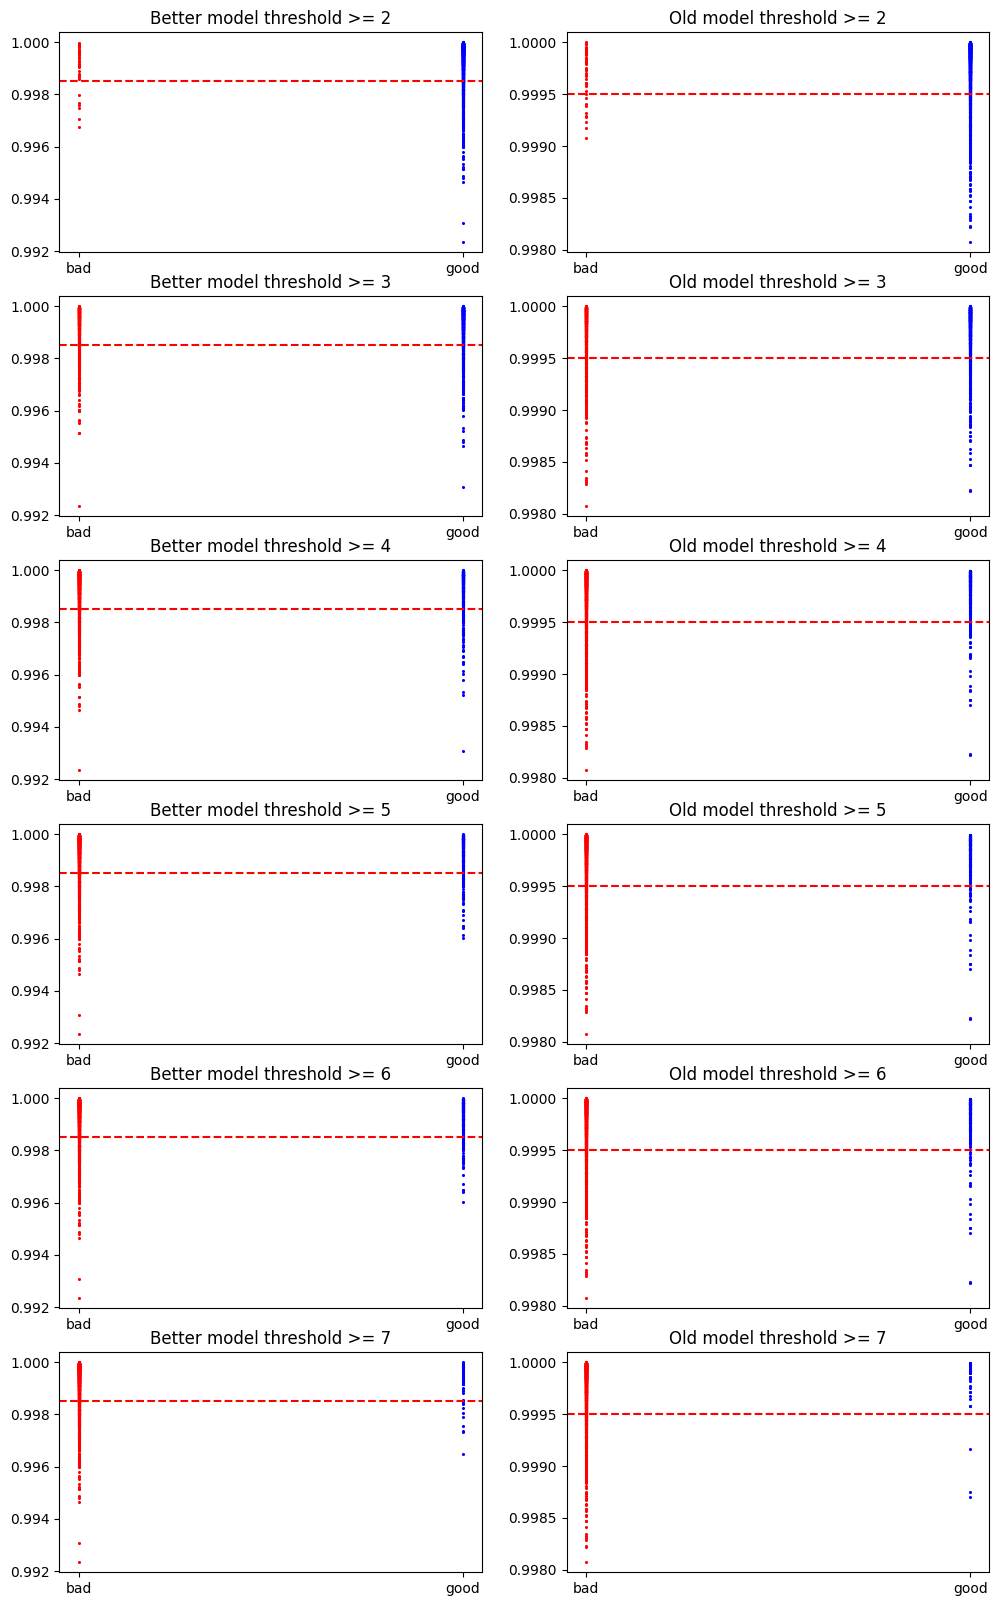

In [6]:
## Plot for original model
df = pd.read_csv("prompt_engineering/sample_2000_labels_combined.csv").iloc[:, 1:]
fig, ax = plt.subplots(6, 2, figsize=(12,20))

for i in range(1, 7):
    df_val = pd.DataFrame({'score': df.score_v1, 'label': df[f"real_v1_threshold_{i}"]})

    df_good = df_val[df_val['label'] == 'good']
    df_bad = df_val[df_val['label'] == 'bad']

    ax[i-1, 0].scatter(df_bad['label'], df_bad['score'], color='red', label='Bad', s=1.5)
    ax[i-1, 0].scatter(df_good['label'], df_good['score'], color='blue', label='Good', s=1.5)
    ax[i-1, 0].axhline(y = 0.9985, color = 'r', linestyle = '--')
    ax[i-1, 0].title.set_text(f'Better model threshold >= {i+1}')
    for theta in range(9300, 10000):
        theta /= 10000
        matching_rate = np.mean( df_val.score >= theta )
        if (i <= 3) and (abs(matching_rate - 0.85) <= 0.07):
            quality_rate = np.mean( df_val[df_val.score >= theta].label == 'good' )
            # if theta == 0.9985:
            #     print( df_val[df_val.score >= theta].label == 'good' )
            print(f"Better model threshold{i}: θ is {theta}, Matching rate is {matching_rate} and Quality rate is {quality_rate}")

    df_val = pd.DataFrame({'score': df.score_v2, 'label': df[f"real_v2_threshold_{i}"]})

    df_good = df_val[df_val['label'] == 'good']
    df_bad = df_val[df_val['label'] == 'bad']

    ax[i-1, 1].scatter(df_bad['label'], df_bad['score'], color='red', label='Bad', s=1.5)
    ax[i-1, 1].scatter(df_good['label'], df_good['score'], color='blue', label='Good', s=1.5)
    ax[i-1, 1].axhline(y = 0.9995, color = 'r', linestyle = '--')
    ax[i-1, 1].title.set_text(f'Old model threshold >= {i+1}')
    for theta in range(9300, 10000):
        theta /= 10000
        matching_rate = np.mean( df_val.score >= theta )
        if (i <= 3) and (abs(matching_rate - 0.85) <= 0.07):
            quality_rate = np.mean( df_val[df_val.score >= theta].label == 'good' )
            # if theta == 0.9985:
            #     print( df_val[df_val.score >= theta].label == 'good' )
            print(f"Old model threshold{i}: θ is {theta}, Matching rate is {matching_rate} and Quality rate is {quality_rate}")
    print()

plt.show()

Better model threshold2: θ is 0.813, Matching rate is 0.849 and Quality rate is 0.644


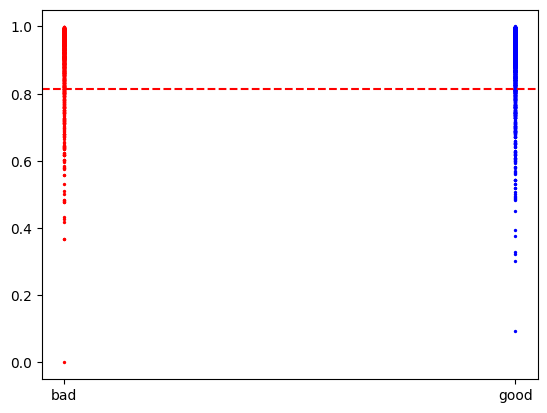

In [9]:
i = 2
df_val = pd.DataFrame({'score': df.score_v1, 'label': df[f"real_v1_threshold_{i}"]})
df_val.score = (df_val.score - df_val.score.min()) / (df_val.score.max() - df_val.score.min())
# df_val.score = np.log( (df_val.score - df_val.score.min()) + 0.01 )

df_good = df_val[df_val['label'] == 'good']
df_bad = df_val[df_val['label'] == 'bad']



# df_val.score = np.log10( df_val.score - df_val.score.min() + 1 )
# df_val.score.plot(kind='hist', bins=20)

plt.scatter(df_bad['label'], df_bad['score'], color='red', label='Bad', s=2)
plt.scatter(df_good['label'], df_good['score'], color='blue', label='Good', s=2)
plt.axhline(y = 0.813, color = 'r', linestyle = '--')

for theta in range(1, 1000):
    theta /= 1000
    matching_rate = np.mean( df_val.score >= theta )
    if (i <= 3) and (abs(matching_rate - 0.85) <= 0.001):
        quality_rate = np.mean( df_val[df_val.score >= theta].label == 'good' )
        # if theta == 0.9985:
        #     print( df_val[df_val.score >= theta].label == 'good' )
        print(f"Better model threshold{i}: θ is {theta}, Matching rate is {matching_rate:.3f} and Quality rate is {quality_rate:.3f}")

## Article 1  --> cos of 6300 videos --> max of cos

,article_title,video_title,score,real
0,Shows like Netflix's live-action 'One Piece' t...,How Icelandic Skyr Yoghurt Cheese is made,0.858191,good
1,Mike Tyson calls Jake Paul his 'hero' and says...,How actors fake fight in movies,0.999435,bad
2,A radio presenter who lost weight and built mu...,Physical therapists debunk 14 more myths about...,0.997589,good
3,"25 best winter coats for women in 2023, tested...",Inside Emirates’ newest and most luxurious fir...,0.878802,bad
4,The Google Pixel 3 has the best smartphone cam...,7 pre-CGI tricks used in classic Hollywood movies,0.986344,bad
5,A reparations case brought by the 1921 Tulsa R...,A criminology student is the suspected killer ...,0.993275,bad
6,"I paid $2,537 for 4 nights of country music at...",Inside America's first private terminal for mi...,0.998344,good
7,We're identical twin sisters who became astrol...,Psychologists debunk 25 mental-health myths,0.873043,good
8,I have a degree in photography. Here's the mos...,The cause of all war boils down to sex and soc...,0.931902,bad
9,Kevin Costner denies any affairs during his ma...,A sleep expert explains what happens to your b...,0.981051,bad


θ is 0.8, Matching rate is 0.95 and Quality rate is 0.35789473684210527
θ is 0.805, Matching rate is 0.94 and Quality rate is 0.3617021276595745
θ is 0.81, Matching rate is 0.94 and Quality rate is 0.3617021276595745
θ is 0.815, Matching rate is 0.94 and Quality rate is 0.3617021276595745
θ is 0.82, Matching rate is 0.94 and Quality rate is 0.3617021276595745
θ is 0.825, Matching rate is 0.94 and Quality rate is 0.3617021276595745
θ is 0.83, Matching rate is 0.94 and Quality rate is 0.3617021276595745
θ is 0.835, Matching rate is 0.93 and Quality rate is 0.3655913978494624
θ is 0.84, Matching rate is 0.93 and Quality rate is 0.3655913978494624
θ is 0.845, Matching rate is 0.93 and Quality rate is 0.3655913978494624
θ is 0.85, Matching rate is 0.93 and Quality rate is 0.3655913978494624
θ is 0.855, Matching rate is 0.93 and Quality rate is 0.3655913978494624
θ is 0.86, Matching rate is 0.92 and Quality rate is 0.358695652173913
θ is 0.865, Matching rate is 0.92 and Quality rate is 0.358

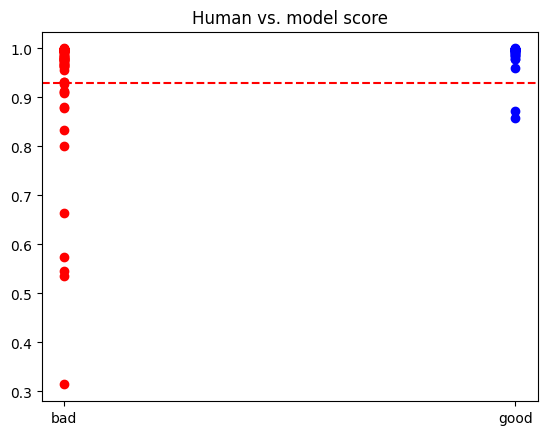

In [4]:
## Plot for better model
df = pd.read_csv("prompt_engineering/sample_100_label.csv").iloc[:, 2:]
display( df.head(15) )
# df_val = pd.DataFrame({'score': df_to_eval.score, 'label': df_to_eval.gpt.apply(lambda x: 1 if x >=2 else 0)})
df_val = pd.DataFrame({'score': df.score, 'label': df.real})

df_good = df_val[df_val['label'] == 'good']
df_bad = df_val[df_val['label'] == 'bad']

# plt.scatter(x=df_val.label, y=df_val.score, s=5)
plt.scatter(df_bad['label'], df_bad['score'], color='red', label='Bad')
plt.scatter(df_good['label'], df_good['score'], color='blue', label='Good')

plt.title(f"Human vs. model score")
plt.axhline(y = 0.93, color = 'r', linestyle = '--')

for theta in range(800, 1000, 5):
    theta /= 1000
    print(f"θ is {theta}, Matching rate is {np.mean(df_val.score >= theta)} and Quality rate is {np.mean( df_val[df_val.score >= theta].label == 'good' )}")

## compute rates (no longer in use)

θ is 0.02, Matching rate is 0.9016544117647058 and Quality rate is 0.2415902140672783
θ is 0.04, Matching rate is 0.8152573529411765 and Quality rate is 0.26268320180383314
θ is 0.06, Matching rate is 0.7518382352941176 and Quality rate is 0.27995110024449876
θ is 0.08, Matching rate is 0.6966911764705882 and Quality rate is 0.2994722955145119
θ is 0.1, Matching rate is 0.6259191176470589 and Quality rate is 0.32305433186490456
θ is 0.12, Matching rate is 0.5680147058823529 and Quality rate is 0.3365695792880259
θ is 0.14, Matching rate is 0.5211397058823529 and Quality rate is 0.3527336860670194
θ is 0.16, Matching rate is 0.4834558823529412 and Quality rate is 0.3688212927756654
θ is 0.18, Matching rate is 0.44485294117647056 and Quality rate is 0.3822314049586777
θ is 0.2, Matching rate is 0.41360294117647056 and Quality rate is 0.3977777777777778
θ is 0.22, Matching rate is 0.37775735294117646 and Quality rate is 0.4233576642335766
θ is 0.24, Matching rate is 0.35294117647058826 an

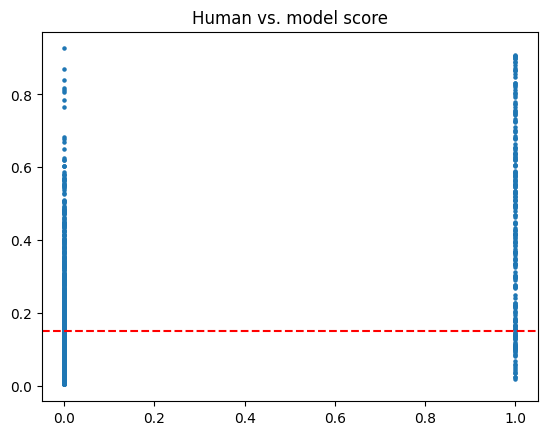

In [ ]:
## Generate 6387 scores for every article
# scores = torch.zeros((150, num_video))
# video_emb = torch.tensor(all_video_embeds).float()

# for idx, article in enumerate(validation_article_emb):
#     ## Emb of each article, repeated 6,387 times to vectorize
#     article_emb = torch.tensor(article).unsqueeze(0).repeat(num_video, 1).float()
#     ## Get score of each (article_i, video_j) pair
#     output = model(article_emb, video_emb)
#     ## map to probability
#     scores[idx] = F.softmax(output, dim=1)[:, 1]

# ## Get idx and highest score of the video for each article
# recommend_score, recommend_idx = torch.max(scores, dim=1)


out, labels = np.array([]), np.array([])
for idx, elem in enumerate(validation_dataloader):
    article_emb, video_emb, label = elem['post_embedding'], elem['video_embedding'], elem['label']

    # print( f"model result is {torch.topk( F.softmax(model(article_emb, video_emb), dim=1)[:, 1], 2)[0][1] }" )
    out = np.append( out, F.softmax(model(article_emb, video_emb), dim=1)[:, 1].detach().numpy() )
    # out = np.append( out, torch.topk( F.softmax(model(article_emb, video_emb), dim=1)[:, 1], 2)[0][1].detach().numpy() )
    labels = np.append( labels, label.detach().numpy() )

# print(out, labels)
df_val = pd.DataFrame({'score': out, 'label': labels})

plt.scatter(x=df_val.label, y=df_val.score, s=5)
plt.title(f"Human vs. model score")
plt.axhline(y = 0.15, color = 'r', linestyle = '--')

for theta in range(2, 100, 2):
    theta /= 100
    print(f"θ is {theta}, Matching rate is {np.mean(df_val.score >= theta)} and Quality rate is {np.mean( df_val[df_val.score >= theta].label == 1 )}")

In [ ]:
## Generate 6387 scores for every article
scores = torch.zeros((150, num_video))
video_emb = torch.tensor(all_video_embeds).float()

for idx, article in enumerate(validation_article_emb):
    ## Emb of each article, repeated 6,387 times to vectorize
    article_emb = torch.tensor(article).unsqueeze(0).repeat(num_video, 1).float()
    ## Get score of each (article_i, video_j) pair
    output = model(article_emb, video_emb)
    ## map to probability
    scores[idx] = F.softmax(output, dim=1)[:, 1]

## Get idx and highest score of the video for each article
recommend_score, recommend_idx = torch.max(scores, dim=1)

NameError: ignored

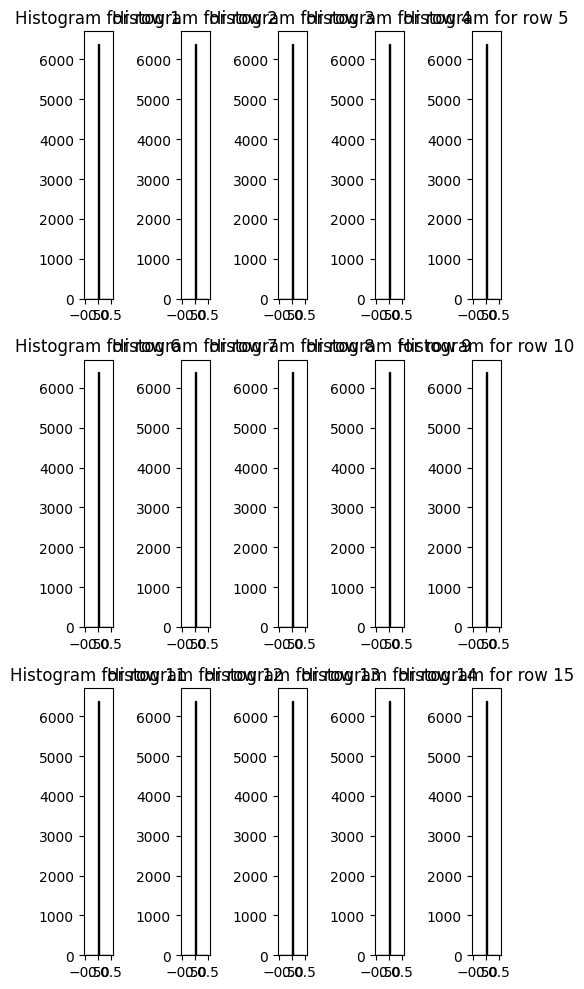

In [ ]:
# import matplotlib.pyplot as plt

# plt.hist( np.log(scores[145, :].detach().numpy()), bins=50 )

# max(scores[145].detach().numpy()), min( scores[145].detach().numpy() )
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure and the grid of subplots
n_rows = 3
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5, 10))  # Adjust the figsize as needed

# For each row in the scores matrix
for idx, row in enumerate(scores[:15]):
    ax = axes[idx // n_cols, idx % n_cols]
    ax.hist(row.detach().numpy(), bins=50, color='skyblue', edgecolor='black')
    ax.set_title(f"Histogram for row {idx+1}")

plt.tight_layout()
plt.show()


In [ ]:
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score
# from sklearn.metrics import confusion_matrix
# from collections import defaultdict

# human_scores = pairs.loc[51:200, 'score'].values
# ## Put a default list, key is θ, value is list of stats
# dic_cutoffs = defaultdict(list)
# ## Iteratively find best θ to maximize Accuracy and F1-score
# for Theta in range(1, 11, 1):
#     GPT_scores = ratings_51_100 + ratings_101_150 + ratings_151_200
#     GPT_scores = np.array( list(map(lambda x: 1 if x >= Theta else 0, GPT_scores)) )

#     accuracy = accuracy_score(GPT_scores, human_scores)
#     precision = precision_score(GPT_scores, human_scores)
#     recall = recall_score(GPT_scores, human_scores)
#     F1 = f1_score(GPT_scores, human_scores)

#     dic_cutoffs[Theta] = [Theta, accuracy, precision, recall, F1]

# stats = list(dic_cutoffs.values()) ## Get dictionary values
# sorted(stats, key=lambda x: x[-1], reverse=True)

# ## 4 or 6 is the best cutoff here

In [ ]:
# probability/calibration
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

pertrue, predprob = calibration_curve(y_test.values, probs[:, 1], n_bins=10)
g = sns.scatterplot(x=predprob, y=pertrue)
g = (g.set(ylim=(0, 1)))
pl.plot([0, 1], [0, 1], color='r', alpha=.3)